#  **Object Detection Using Adaptive Mask RCNN in Optical Remote Sensing Images**

### **Business Understanding:**

**BO1:** Enhance object detection in remote sensing images.</br>
**DSO1:** Utilize the adaptive mask RCNN approach for multi-class object detection in remote sensing images.

**BO2:** Overcome limitations of traditional object detection methods.</br>
**DSO2:** Apply transfer learning techniques and fine-tuning to adapt the mask-RCNN model.

**BO3:** Provide a fast and automatic solution for object detection.</br>
**DSO3:** Investigate and compare optimization methods to improve efficiency and effectiveness.

**BO4:** Improve accuracy and efficiency in object detection.</br>
**DSO4:** Evaluate performance on NWPU-VHR-10 dataset using accuracy precision and IOU metrics.

### **Data Understanding:**

**Data Description:**

The NWPU VHR-10 dataset used in this study is a very-high-resolution (VHR) remote sensing image dataset constructed by Dr. Gong Cheng et al. from Northwestern Polytechnical University (NWPU). It is a 10-class geospatial object detection dataset intended for research purposes. The ten object classes in the dataset are airplane, ship, storage tank, baseball diamond, tennis court, basketball court, ground track field, harbor, bridge, and vehicle.

The dataset comprises a total of 800 VHR remote sensing images. The "negative image set" folder contains 150 images that do not contain any targets of the specified object classes. On the other hand, the "positive image set" folder consists of 650 images, each containing at least one target object to be detected.

These images were sourced from Google Earth and the Vaihingen dataset, and then manually annotated by domain experts. The Vaihingen data was provided by the German Society for Photogrammetry, Remote Sensing and Geoinformation (DGPF). The "ground truth" folder contains 650 text files, with each file corresponding to an image in the "positive image set" folder. Each line of the text files represents a ground truth bounding box and is formatted as (x1,y1),(x2,y2),a, where (x1,y1) denotes the top-left coordinate of the bounding box, (x2,y2) denotes the bottom-right coordinate, and 'a' represents the object class label (1-airplane, 2-ship, 3-storage tank, 4-baseball diamond, 5-tennis court, 6-basketball court, 7-ground track field, 8-harbor, 9-bridge, 10-vehicle).



**Proposed solution:**

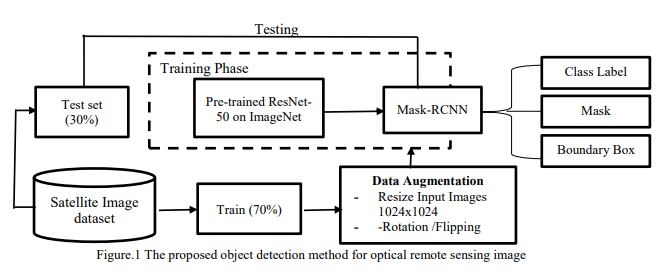

### **Data Preparation:**

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

2024-05-05 22:26:21.335703: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-05 22:26:21.335831: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-05 22:26:21.462093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Imported essential libraries for image processing, data handling.

OpenCV (cv2) is used for image manipulation, NumPy for numerical operations, Pandas for data manipulation, and TensorFlow for building and training deep learning models.

The scikit-learn library is utilized for data splitting.

Additionally, specific components from the TensorFlow Keras module, such as ResNet50 model architecture and layers, are imported for building a custom model.

**Loading and resizing data**

This is the process of loading images and their corresponding annotations from directories.

The load_data function takes two arguments: the directory paths for images and annotations. It iterates through each image file in the specified directory, loads the image using OpenCV, resizes it to 1024x1024 pixels, and parses the corresponding annotation file to extract bounding box coordinates and class labels.

The process_line function is utilized to clean and extract information from each annotation line, enabling accurate parsing of ground truth bounding boxes. These bounding boxes are defined in text files within the "ground truth" folder, with each file corresponding to an image in the "positive image set" folder. Each line of these text files adheres to the format: (x1,y1),(x2,y2),a, where (x1,y1) signifies the top-left coordinate, (x2,y2) denotes the bottom-right coordinate, and 'a' represents the object class.

After processing, the loaded images and annotations are stored in lists for further analysis and model training. Additionally, to aid interpretation, class labels are predefined, with numerical labels mapped to their respective object classes (e.g., 1-airplane, 2-ship, etc.).

In [4]:
import os
import cv2

# Define function to process each annotation line
def process_line(line):
    # Clean and split the line to extract numbers
    cleaned_text = line.strip().replace('(', '').replace(')', '')
    numbers = cleaned_text.split(',')

    # Check if we have enough values to unpack
    if len(numbers) != 5:
        return None

    # Extract numerical values and class label
    x1, y1, x2, y2, class_label = map(int, numbers)
    return x1, y1, x2, y2, class_label


def load_data(image_dir, annotation_dir):
    images = []
    annotations = []

    for filename in os.listdir(image_dir):
        if filename.endswith(".jpg"):
            image_path = os.path.join(image_dir, filename)
            annotation_path = os.path.join(annotation_dir, filename.replace(".jpg", ".txt"))

            # Load image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Resize image to 1024x1024
            resized_image = cv2.resize(image, (1024, 1024))
            images.append(resized_image)

            # Parse annotations
            with open(annotation_path, 'r') as file:
                boxes = []
                for line in file:
                    annotation = process_line(line)
                    if annotation is not None:
                        # Adjust annotations for resizing
                        x1, y1, x2, y2, class_label = annotation
                        x1_resized = int(x1 * 1024 / image.shape[1])
                        y1_resized = int(y1 * 1024 / image.shape[0])
                        x2_resized = int(x2 * 1024 / image.shape[1])
                        y2_resized = int(y2 * 1024 / image.shape[0])
                        boxes.append([x1_resized, y1_resized, x2_resized, y2_resized, class_label])
                annotations.append(boxes)

    return images, annotations



image_dir = '/kaggle/input/dataset1/data/positive image set'
annotation_dir = '/kaggle/input/dataset1/data/ground truth'
images, annotations = load_data(image_dir, annotation_dir)

# Define class labels
class_labels = {
    1: "airplane",
    2: "ship",
    3: "storage tank",
    4: "baseball diamond",
    5: "tennis court",
    6: "basketball court",
    7: "ground track field",
    8: "harbor",
    9: "bridge",
    10: "vehicle"
}


**Splitting**

When performing the dataset split, we adopted a consistent strategy for both images and annotations. A stratified approach was utilized, randomly selecting 500 images from the positive image set for training, with the remaining 150 images reserved for evaluation.

In [5]:
train_images, test_images, train_annotations, test_annotations = train_test_split(
    images, annotations, test_size=0.23, random_state=42)

In [6]:
print("Number of loaded images:", len(images))
print("Number of loaded annotations:", len(annotations))


Number of loaded images: 650
Number of loaded annotations: 650


#### **Data Augmentation**

**Rotation:**

**rotate_point(x, y, angle):** This function rotates a given point (x, y) around the origin (0, 0) by a specified angle in degrees. It calculates the new coordinates of the point after rotation, which is useful for adjusting the positions of objects or landmarks within an image during rotation.

**rotate_annotations(annotations, angle, image_width, image_height):** This function applies rotation to the bounding box coordinates of the annotations. It shifts the coordinates to the origin, rotates them around the image's center, and adjusts them back to their original positions. By rotating the annotations, we ensure that they remain aligned with the rotated image, enabling the model to learn from different orientations of the objects.

In [7]:
def rotate_point(x, y, angle):
    # Rotate point (x, y) around the origin (0, 0) by given angle in degrees
    angle_rad = np.deg2rad(angle)
    rotated_x = int(np.cos(angle_rad) * x - np.sin(angle_rad) * y)
    rotated_y = int(np.sin(angle_rad) * x + np.cos(angle_rad) * y)
    return rotated_x, rotated_y

def rotate_annotations(annotations, angle, image_width, image_height):
    rotated_annotations = []
    center_x = image_width / 2
    center_y = image_height / 2
    for x1, y1, x2, y2, class_id in annotations:
        # Translate the coordinates to the origin
        x1 -= center_x
        y1 -= center_y
        x2 -= center_x
        y2 -= center_y

        # Rotate bounding box coordinates around the origin
        rotated_x1 = int(np.cos(np.radians(angle)) * x1 - np.sin(np.radians(angle)) * y1) + center_x
        rotated_y1 = int(np.sin(np.radians(angle)) * x1 + np.cos(np.radians(angle)) * y1) + center_y
        rotated_x2 = int(np.cos(np.radians(angle)) * x2 - np.sin(np.radians(angle)) * y2) + center_x
        rotated_y2 = int(np.sin(np.radians(angle)) * x2 + np.cos(np.radians(angle)) * y2) + center_y

        rotated_annotations.append([rotated_x1, rotated_y1, rotated_x2, rotated_y2, class_id])
    return rotated_annotations



**Flipping:**

**flip_annotations(annotations, flip_code, image_width, image_height):** This function flips the bounding box coordinates of the annotations based on the given flip code. It adjusts the x and y values of the coordinates to reflect the flipping direction. The three flip codes allow for horizontal, vertical, and combined horizontal and vertical flipping operations. Flipping the annotations horizontally or vertically enables the model to learn from images with mirrored or inverted objects, enhancing its ability to recognize objects in various orientations.

In [8]:
def flip_annotations(annotations, flip_code, image_width, image_height):
    flipped_annotations = []
    for x1, y1, x2, y2, class_id in annotations:
        # Flip bounding box coordinates
        if flip_code == 1:  # Horizontal flip
            flipped_x1 = image_width - x2
            flipped_x2 = image_width - x1
            flipped_y1, flipped_y2 = y1, y2
        elif flip_code == 0:  # Vertical flip
            flipped_y1 = image_height - y2
            flipped_y2 = image_height - y1
            flipped_x1, flipped_x2 = x1, x2
        elif flip_code == -1:  # Both horizontal and vertical flip
            flipped_x1 = image_width - x2
            flipped_x2 = image_width - x1
            flipped_y1 = image_height - y2
            flipped_y2 = image_height - y1
        flipped_annotations.append([flipped_x1, flipped_y1, flipped_x2, flipped_y2, class_id])
    return flipped_annotations

**Applying the Augmentation:**

**augment_data(images, annotations):** This function takes a set of images and their corresponding annotations as input and generates augmented versions of the data. It includes the original image and annotations, as well as variations obtained through rotation and flipping operations.

In [9]:
def augment_data(images, annotations):
    augmented_images = []
    augmented_annotations = []

    for image, image_annotations in zip(images, annotations):
        # Original image and annotations
        augmented_images.append(image)
        augmented_annotations.append(image_annotations)

        # Rotate the image by 180 degrees
        for angle in [180]:
            rotated_image = np.rot90(image, k=angle // 90)
            rotated_annotations = rotate_annotations(image_annotations, angle, image.shape[1], image.shape[0])
            augmented_images.append(rotated_image)
            augmented_annotations.append(rotated_annotations)

        # Flip the image horizontally and vertically
        for flip_code in [1, 0, -1]:
            flipped_image = cv2.flip(image, flip_code)
            flipped_annotations = flip_annotations(image_annotations, flip_code, image.shape[1], image.shape[0])
            augmented_images.append(flipped_image)
            augmented_annotations.append(flipped_annotations)

    return augmented_images, augmented_annotations


# Apply data augmentation to the training set
augmented_train_images, augmented_train_annotations = augment_data(train_images, train_annotations)


**Data After Augmentation:**

In [10]:
print("Number of train images:", len(train_images))
print("Number of augmented train images:", len(augmented_train_images))
print("Number of train annotations:", len(train_annotations))
print("Number of augmented train annotations:", len(augmented_train_annotations))


Number of train images: 500
Number of augmented train images: 2500
Number of train annotations: 500
Number of augmented train annotations: 2500


**Visualizing augmented data:**

This code segment serves to visualize augmented images by drawing bounding boxes and adding class names. It iterates over a range of augmented images, retrieves the annotations, and displays the modified images with annotations. This allows for a visual inspection and evaluation of the augmented data for object detection or localization tasks.

Annotations for Augmented Image 1: [[367, 262, 735, 801, 7], [286, 204, 392, 322, 4], [773, 474, 852, 565, 4]]


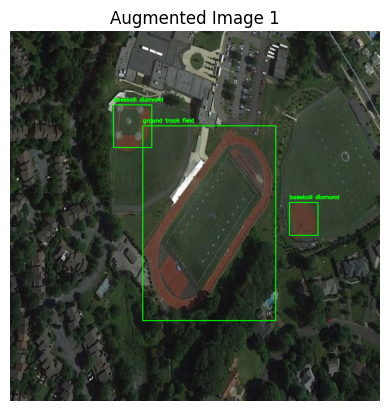

Annotations for Augmented Image 2: [[657.0, 761.0, 289.0, 223.0, 7], [738.0, 820.0, 632.0, 701.0, 4], [251.0, 550.0, 172.0, 460.0, 4]]


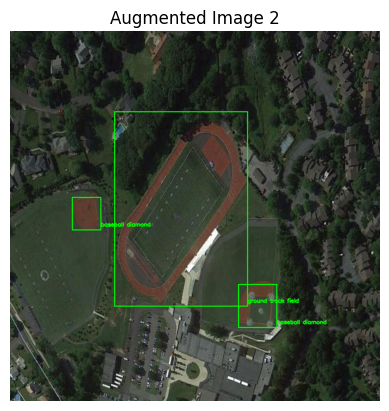

Annotations for Augmented Image 3: [[289, 262, 657, 801, 7], [632, 204, 738, 322, 4], [172, 474, 251, 565, 4]]


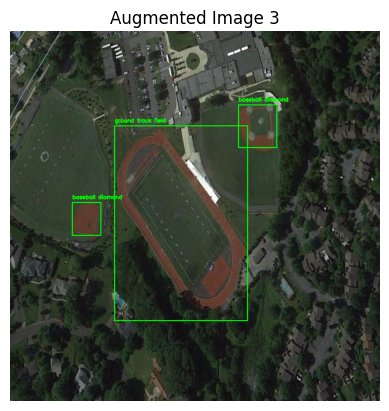

Annotations for Augmented Image 4: [[367, 223, 735, 762, 7], [286, 702, 392, 820, 4], [773, 459, 852, 550, 4]]


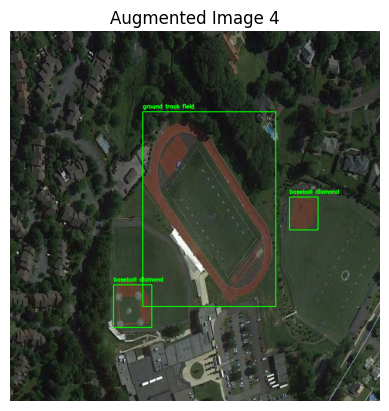

Annotations for Augmented Image 5: [[289, 223, 657, 762, 7], [632, 702, 738, 820, 4], [172, 459, 251, 550, 4]]


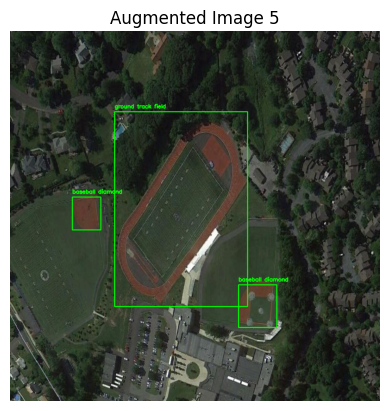

Annotations for Augmented Image 6: [[419, 183, 648, 675, 7]]


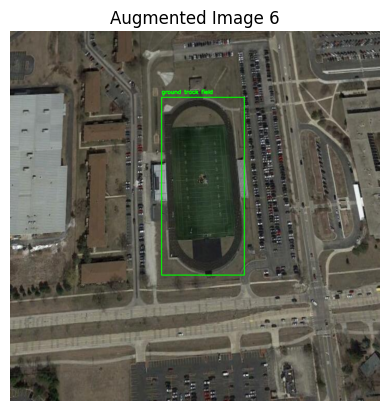

Annotations for Augmented Image 7: [[605.0, 841.0, 376.0, 350.0, 7]]


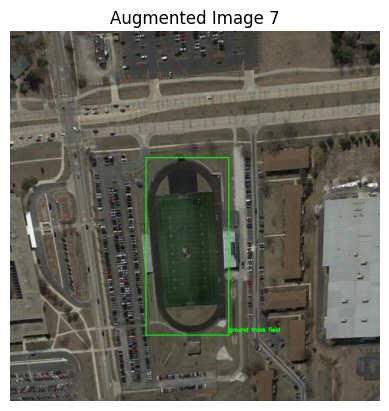

Annotations for Augmented Image 8: [[376, 183, 605, 675, 7]]


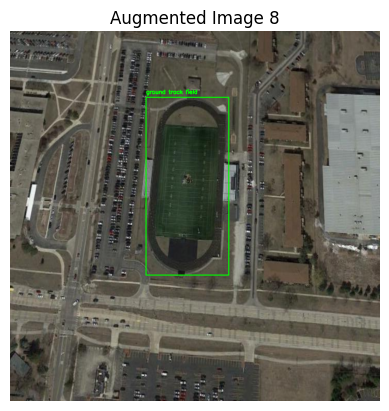

Annotations for Augmented Image 9: [[419, 349, 648, 841, 7]]


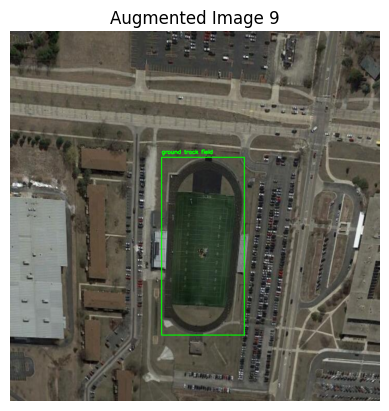

Annotations for Augmented Image 10: [[376, 349, 605, 841, 7]]


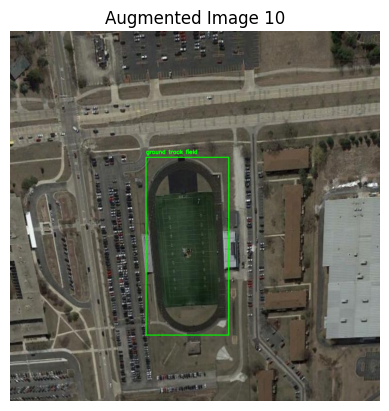

Annotations for Augmented Image 11: [[272, 83, 548, 196, 9], [378, 659, 678, 810, 9]]


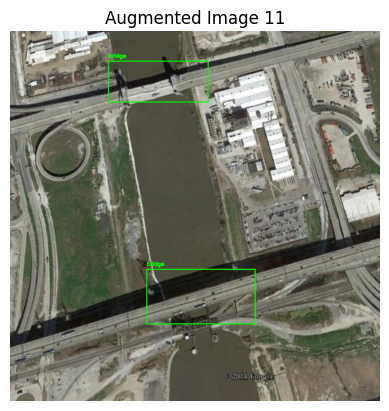

Annotations for Augmented Image 12: [[752.0, 940.0, 477.0, 828.0, 9], [645.0, 365.0, 346.0, 214.0, 9]]


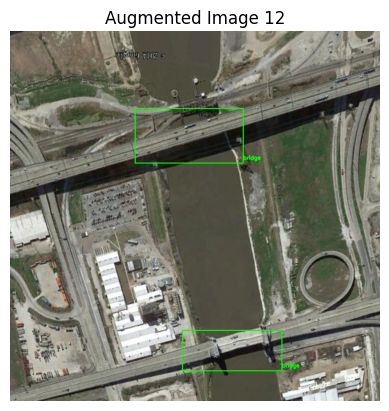

In [11]:
import matplotlib.pyplot as plt

def draw_boxes(image, annotations):
    for annotation in annotations:
        x1, y1, x2, y2, class_id = annotation
        class_name = class_labels[class_id]
        # Convert coordinates to integers
        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

# Visualize augmented images with bounding boxes and class names
for i in range(12):
    image = augmented_train_images[i]
    annotations = augmented_train_annotations[i]
    print(f"Annotations for Augmented Image {i+1}: {annotations}")
    image_with_boxes = draw_boxes(image.copy(), annotations)
    plt.imshow(image_with_boxes)
    plt.axis('off')
    plt.title(f"Augmented Image {i+1}")
    plt.show()


### **Modeling:**

**Mask_RCNN:**

The Mask_RCNN function creates a Mask R-CNN model using a pre-trained ResNet50 backbone and customizes it based on the provided input shape and fine-tuning strategy.

The function begins by initializing the backbone using the ResNet50 architecture with pre-trained weights from the ImageNet dataset. The input shape of the model is specified as an argument.

Next, depending on the chosen fine-tuning strategy, certain layers of the backbone are frozen to prevent their weights from being updated during training. There are three possible strategies:

Fine-tune only the head layer by unfreezing the last five layers of the backbone.
Fine-tune up to the convolution layer (+4) by unfreezing the layers up to the 17th layer from the end of the backbone.
Fine-tune up to the convolution layer (+3) by unfreezing the layers up to the 34th layer from the end of the backbone.
After setting the fine-tuning strategy, the function constructs the Feature Pyramid Network (FPN) by selecting specific layers from the backbone as pyramid layers.

Then, the function defines the Region Proposal Network (RPN) by applying convolutional layers to the backbone output. Several Conv2D layers are shown as examples, but more layers can be defined based on specific requirements.

Similarly, the function defines the Fully Convolutional Network (FCN) for mask prediction by applying convolutional transpose (Conv2DTranspose) layers to the backbone output. Again, example layers are provided, but additional layers can be defined as needed.

Finally, the function creates the final model by specifying the inputs as the backbone's input and the outputs as the RPN output and mask output. The model is then returned.

In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy

def Mask_RCNN(input_shape, fine_tune_strategy):
    # Backbone (ResNet50)
    backbone = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze layers based on fine-tuning strategy
    if fine_tune_strategy == 1:
        # Freeze all layers except the head layer
        for layer in backbone.layers[:-5]:
            layer.trainable = False
    elif fine_tune_strategy == 2:
        # Freeze layers up to convolution layer (+4)
        for layer in backbone.layers[:-17]:
            layer.trainable = False
    elif fine_tune_strategy == 3:
        # Freeze layers up to convolution layer (+3)
        for layer in backbone.layers[:-34]:
            layer.trainable = False
    
    # Feature Pyramid Network (FPN)
    pyramid_layers = [backbone.get_layer(name).output for name in ["conv2_block3_out", "conv3_block4_out", "conv4_block6_out"]]
    
    # Region Proposal Network (RPN)
    rpn_input = backbone.output
    rpn_output = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(rpn_input) # Example layer
    # Define more RPN layers...
    rpn_output = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(rpn_output)
    rpn_output = Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(rpn_output)
    
    # Fully Convolutional Network (FCN) for Mask
    fcn_input = backbone.output
    mask_output = Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(fcn_input) # Example layer
    # Define more FCN layers...
    mask_output = Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(mask_output)
    mask_output = Conv2DTranspose(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')(mask_output)
    
    # Define final model
    model = Model(inputs=backbone.input, outputs=[rpn_output, mask_output])
    
    return model



**Loss function:**

The mask_rcnn_loss function calculates the total loss for a Mask R-CNN model during training. It consists of three components: the classification loss, bounding box loss, and mask loss.

The classification loss is computed using binary cross-entropy between the true class labels and the predicted class probabilities. It measures the dissimilarity between the predicted and true class distributions.

The bounding box loss, specific details of which are not provided in the code segment, measures the difference between the predicted bounding box coordinates and the true bounding box coordinates. It helps in accurately localizing objects.

The mask loss is based on Equation (2) from the Mask R-CNN paper. It involves the true masks and predicted masks. The loss is calculated using the negative mean of the sum of element-wise products of the logarithm of the predicted masks and the true masks, as well as the logarithm of the complementary masks. This loss encourages accurate pixel-wise predictions for object segmentation.

The total loss is obtained by summing the classification loss, bounding box loss, and mask loss. This combined loss is used to optimize the Mask R-CNN model during training.

Finally, the function returns the total loss, which can be used for further training and model improvement.

In [13]:
def mask_rcnn_loss(y_true, y_pred):
    classification_loss = binary_crossentropy(y_true[0], y_pred[0])
    bounding_box_loss = binary_crossentropy(y_true[1], y_pred[1])  # Example bounding box loss
    
    # Mask loss according to Eq. (2)
    mask_true, mask_pred = y_true[2], y_pred[2]
    mask_loss = -tf.reduce_mean(
        tf.reduce_sum(
            mask_true * tf.math.log(mask_pred) +
            (1 - mask_true) * tf.math.log(1 - mask_pred),
            axis=[1, 2]
        )
    )
    
    total_loss = classification_loss + bounding_box_loss + mask_loss
    return total_loss



**Training the model:**

The train_model function trains a Mask R-CNN model using the provided images and annotations. It takes the model, images, annotations, number of epochs, batch size, and learning rate as input.

The function begins by creating an Adam optimizer with the specified learning rate and compiling the model with the mask_rcnn_loss function as the loss function.

Next, the input data is prepared as a list of dictionaries. Each dictionary contains the input image, input boxes, input classes, and input masks. The annotations are iterated over, and the boxes and masks are converted to NumPy arrays before being added to the input data list. Similarly, the output data is prepared with the output boxes, output classes, and output masks.

The model is then trained using the fit function, passing the input data and output data. The specified number of epochs and batch size are used during training.

In [14]:
def train_model(model, images, annotations, epochs=10, batch_size=32, learning_rate=0.001):
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=mask_rcnn_loss)
    
    # Prepare input data as a list of dictionaries
    input_data = []
    output_data = []
    for image, annotation in zip(images, annotations):
        boxes_array = np.array([np.array(box) for box in annotation['boxes']])
        input_data.append({
            'input_image': np.array(image),
            'input_boxes': boxes_array,
            'input_classes': np.array(annotation['classes']),
            'input_masks': np.array(annotation['masks'])
        })
        output_data.append({
            'output_boxes': boxes_array,
            'output_classes': np.array(annotation['classes']),
            'output_masks': np.array(annotation['masks'])
        })
    
    # Train the model
    model.fit(input_data, output_data, epochs=epochs, batch_size=batch_size)



Following the function definition, the code sets the desired height and width for the resized images.

The augmented data is prepared for model training by formatting the annotations. For each annotation, the boxes are formatted and masks are created based on the specified image height and width. The formatted annotations are stored in a list.

The images, boxes, classes, and masks are extracted from the formatted annotations.

In [15]:
# Define the fixed size of the resized images
image_height = 1024
image_width = 1024

# Prepare augmented data for model training
formatted_annotations = []
for annotation in augmented_train_annotations:
    formatted_boxes = []
    formatted_masks = []
    for box in annotation:
        x1, y1, x2, y2, class_label = box
        formatted_boxes.append([x1, y1, x2, y2])
        # Create mask
        mask = np.zeros((image_height, image_width))
        mask[int(y1 * image_height):int(y2 * image_height), int(x1 * image_width):int(x2 * image_width)] = 1
        formatted_masks.append(mask)
    formatted_annotations.append({'boxes': formatted_boxes, 'classes': [class_label], 'masks': formatted_masks})

# Extract images, boxes, classes, and masks from formatted annotations
images = augmented_train_images
boxes = [annotation['boxes'] for annotation in formatted_annotations]
classes = [annotation['classes'] for annotation in formatted_annotations]
masks = [annotation['masks'] for annotation in formatted_annotations]



The code then specifies the fine-tuning strategy, with the value of 1 indicating fine-tuning up to the convolution layer (+4).

Finally, the Mask_RCNN model is instantiated with the specified input shape, and the train_model function is called to train the model using the images and formatted annotations for a specified number of epochs, batch size, and learning rate.

In [ ]:
# Fine-tuning strategy
fine_tune_strategy = 1

# Train the model
input_shape = (image_height, image_width, 3)
model = Mask_RCNN(input_shape, fine_tune_strategy)
train_model(model, images, formatted_annotations, epochs=30, batch_size=32, learning_rate=0.1)


### **Evaluation:**

predictions = model.predict(test_images) is responsible for obtaining predictions from the model for the provided test images. It utilizes the trained model to predict the output for each image in the test set, producing predictions such as bounding box coordinates, class labels, and confidence scores. These predictions are then used for further evaluation

In [ ]:
# Evaluate the model
predictions = model.predict(test_images)

**Intersection over Union (IoU):**

a metric used to evaluate the accuracy of object detection algorithms. It measures the overlap between the predicted bounding box and the ground truth bounding box. Higher IoU indicates better detection accuracy.

In [ ]:
def calculate_iou(box1, box2):
    # Implement the Intersection over Union (IoU) calculation
    x1_int = max(box1[0], box2[0])
    y1_int = max(box1[1], box2[1])
    x2_int = min(box1[2], box2[2])
    y2_int = min(box1[3], box2[3])
    
    intersection_area = max(0, x2_int - x1_int + 1) * max(0, y2_int - y1_int + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


**Average Precision (AP):**

a metric commonly used to evaluate the performance of object detection models. It calculates the average precision-recall curve over all classes. AP provides a single numerical value summarizing the precision-recall trade-off of the model.

In [ ]:
def compute_ap(y_true, y_pred):
    ap_scores = []
    for true_boxes, pred_boxes in zip(y_true, y_pred):
        ap_scores_per_class = []
        for true_box in true_boxes:
            iou_scores = [calculate_iou(true_box, pred_box) for pred_box in pred_boxes]
            best_iou = max(iou_scores)
            ap_scores_per_class.append(best_iou)
        ap_scores.append(np.mean(ap_scores_per_class))
    return np.mean(ap_scores)

iou = compute_ap(test_annotations, predictions[0])
print("Mean IoU:", iou)

**The Precision-Recall curve:**

a graphical representation of the trade-off between precision and recall for different thresholds of confidence scores. It helps visualize the model's performance across various levels of classification confidence.

In [ ]:
def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, marker='.')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()


**Average Precision-Recall score**

It quantifies the overall performance of the model by computing the area under the Precision-Recall curve. It provides a single metric to compare different models or configurations.

In [ ]:
from sklearn.metrics import average_precision_score

# You need to obtain confidence scores from your model predictions
y_scores = []  
plot_precision_recall_curve(test_annotations, y_scores)

# Compute average precision
average_precision = average_precision_score(test_annotations, y_scores)
print('Average precision-recall score: {0:0.2f}'.format(average_precision))


**Computation time** 

refers to the time taken by the model to process a set of test images and make predictions. It is an important factor to consider when evaluating the efficiency of the model in real-world applications.

In [ ]:
# Compute computation time
import time

start_time = time.time()
predictions = model.predict(test_images)
end_time = time.time()
total_time = end_time - start_time
print("Total Inference Time:", total_time)

**Loss and Accuracy**

In [ ]:
# Evaluate performances using loss and accuracy in addition to precision and recall
loss, accuracy = model.evaluate(test_images, test_annotations)
print("Loss:", loss)
print("Accuracy:", accuracy)

**Conclusion:**

In this implementation, we aimed to replicate the methodology outlined in the paper "Object Detection Using Adaptive Mask RCNN in Optical Remote Sensing Images." The code not only loads and preprocesses the dataset but also applies data augmentation techniques, such as rotation and flipping, to enrich the training data. Additionally, the model architecture utilizes ResNet50 as a backbone for feature extraction, while incorporating the Mask R-CNN framework for precise instance segmentation. Following training, we evaluated the model's performance using metrics such as Intersection over Union (IoU), Average Precision (AP), and computation time. These evaluation steps aimed to provide a comprehensive assessment of the model's efficacy in object detection and instance segmentation, as proposed in the referenced paper.